[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.347178  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.661272  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.663507  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.995314  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.917265  27.972500  28.037500  27.174999  27.307501  237458000
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0242 - val_loss: 0.0017
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 39m

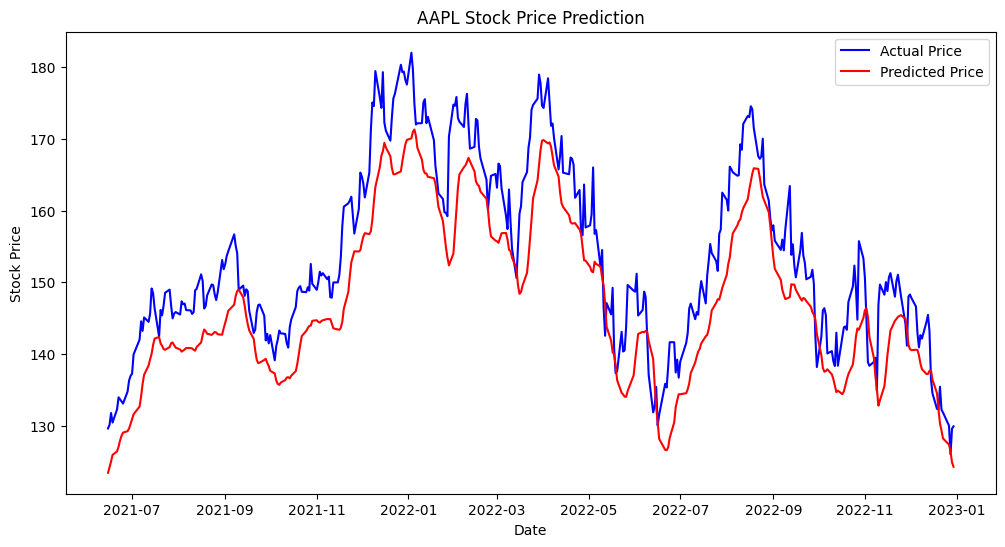

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

# ----------------- Fetch Historical Stock Data -----------------

def get_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using Yahoo Finance.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# ----------------- Data Preprocessing -----------------

def prepare_data(data, lookback=30):
    """
    Prepare the data for the neural network by creating input sequences.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# ----------------- Build ANN Model -----------------

def build_ann_model(input_shape):
    """
    Build a simple ANN model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Single output neuron for predicting closing price
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# ----------------- Main Function -----------------

def main():
    # Parameters
    ticker = 'AAPL'  # Apple stock
    start_date = '2015-01-01'
    end_date = '2023-01-01'
    lookback = 60

    # Fetch the stock data
    data = get_stock_data(ticker, start_date, end_date)
    print(data.head())

    # Prepare the data
    X, y, scaler = prepare_data(data, lookback)

    # Split the data into training and testing sets (80% train, 20% test)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the model
    model = build_ann_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Predict on the test set
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
    plt.plot(data.index[-len(predictions):], predictions, label='Predicted Price', color='red')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
